<a href="https://colab.research.google.com/github/nandani537/Assigment-2--ML-to-DL/blob/main/Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CS-E4740 - Federated Learning D (Spring 25)

Assignment 2: From ML To FL

Importing necessary libraries

In [ ]:
import networkx as nx  # NetworkX: Used for creating and analyzing graphs and networks

import numpy as np  # NumPy: Provides support for large, multi-dimensional arrays and mathematical operations

import pandas as pd  # Pandas: Used for data manipulation and analysis, especially with tabular data

import matplotlib.pyplot as plt  # Matplotlib: A plotting library for visualizing data

from scipy.spatial import distance_matrix  # SciPy's spatial module: Computes pairwise distance matrices between points

from scipy.linalg import eigh  # SciPy's linear algebra module: Computes eigenvalues and eigenvectors of symmetric matrices

** TASK 2.1: Building a FL Network**

In this task you have to implement a function generate_FL_network(n_stations) that creates a federated learning (FL) network with a given number of nodes.

The network should be characterized using a dataframe station_data containing metadata for the entire network. In particulat, the dataframe contains, for each node,

Latitude (latitude) between 60 and 65 (randomly generated)
Longitude (longitude) between 24 and 30 (randomly generated)
Temperature statistics: temperature_mean between -10 and 20, and temperature_std between 1 and 5 (randomly generated)

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

def generate_FL_network(n_stations):
    """
    Generates a federated learning (FL) network with `n_stations` nodes,
    where each node represents an FMI station with a local dataset.
    """
    # Set random seed for reproducibility
    np.random.seed(42)

    # Generate random metadata for each station (latitude, longitude, temperature stats)
    station_data = pd.DataFrame({
        "latitude": np.random.uniform(60, 65, n_stations),
        "longitude": np.random.uniform(24, 30, n_stations),
        "temperature_mean": np.random.uniform(-10, 20, n_stations),
        "temperature_std": np.random.uniform(1, 5, n_stations)
    })

    # Initialize an empty graph
    G = nx.Graph()

    # Add nodes to the graph, each carrying a local dataset
    for idx, row in station_data.iterrows():
        # Simulate a dataset of 100 temperature values with Gaussian distribution
        local_dataset = np.random.normal(row["temperature_mean"], row["temperature_std"], 100)

        # Add node with attributes
        G.add_node(
            idx,
            lat=row["latitude"],
            lon=row["longitude"],
            dataset=local_dataset.tolist()  # Convert numpy array to list for JSON serialization
        )

    return G, station_data

n_stations = 10
G_geo, geo_station_data = generate_FL_network(n_stations)
G_stat, stat_station_data = generate_FL_network(n_stations)

print(geo_station_data)
print("\nGraph Nodes with Attributes:")
for node, attr in G_geo.nodes(data=True):
    print(f"Node {node}: {attr}")


    latitude  longitude  temperature_mean  temperature_std
0  61.872701  24.123507          8.355587         3.430179
1  64.753572  29.819459         -5.815184         1.682096
2  63.659970  28.994656         -1.235661         1.260206
3  62.993292  25.274035          0.990855         4.795542
4  60.780093  25.090950          3.682100         4.862528
5  60.779973  25.100427         13.555279         4.233589
6  60.290418  25.825453         -4.009787         2.218455
7  64.330881  27.148539          5.427033         1.390688
8  63.005575  26.591670          7.772437         3.736932
9  63.540363  25.747375         -8.606488         2.760610

Graph Nodes with Attributes:
Node 0: {'lat': 61.87270059423681, 'lon': 24.123506965774816, 'dataset': [8.309288939315497, 4.7274485939673045, 11.177063460998628, 4.167874093634539, 9.072026444255206, 1.6335667370387634, 3.7996704072707406, 9.030856199105472, 10.888659697576689, 8.943410790926015, 7.958892484898268, 7.322747145507016, 3.283991156620

In [ ]:
# Sanity checks

# Test that the graph has the correct number of nodes
assert len(G_geo.nodes) == 10, "Number of nodes in the FL network is incorrect"
assert len(G_stat.nodes) == 10, "Number of nodes in the FL network is incorrect"

print('Sanity check passed!')

Sanity check passed!


**TASK 2.2:** Construct Edges in the FL Network
Your goal is to implement a function construct_edges(G, station_data, method) that constructs edges in the Federated Learning (FL) network graph based on different distance metrics. This function will add edges to a given FL network graph (G), passed as input parameter.

**Parameters**
G (networkx.Graph): An undirected graph representing the FL network. The function should modify G by adding edges.

station_data (pd.DataFrame): A DataFrame containing node attributes,including geographical and statistical features.

method (str): A string that indicates how to compute distances between nodes. Supported values:

'geo': Uses latitude and longitude to compute geographical distances.
'stat': Uses temperature_mean and temperature_std to compute statistical distances.

In [ ]:
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx

def construct_edges(G, station_data, method):
    """
    Constructs edges in the graph by connecting each node to its 5 nearest neighbors.
    Two methods are supported:
    - 'geo': Uses latitude and longitude to compute distances.
    - 'stat': Uses temperature mean and standard deviation to compute distances.
    """
    n = len(G.nodes)

    # Initialize coords as a NumPy array with the correct shape
    if method == 'geo':
        # Use geographical coordinates (latitude, longitude)
        coords = station_data[['latitude', 'longitude']].to_numpy()
    elif method == 'stat':
        # Use statistical temperature features (temperature_mean, temperature_std)
        coords = station_data[['temperature_mean', 'temperature_std']].to_numpy()
    else:
        raise ValueError("Method must be 'geo' or 'stat'.")

    # Compute pairwise distances between all nodes
    dist_matrix = distance_matrix(coords, coords)

    for i in range(n):
        # Get indices of the 5 nearest neighbors, excluding the node itself
        nearest_neighbors = np.argsort(dist_matrix[i])[1:6]

        for j in nearest_neighbors:
            # Add an edge between node i and node j with distance as weight
            G.add_edge(i, j, weight=dist_matrix[i, j])

    return G


G_geo = construct_edges(G_geo, geo_station_data, method='geo')
G_stat = construct_edges(G_stat, geo_station_data, method='stat')


print("\nGeographical Graph Edges:")
for u, v, attr in G_geo.edges(data=True):
    print(f"Edge {u}-{v}, Weight: {attr['weight']}")


print("\nStatistical Graph Edges:")
for u, v, attr in G_stat.edges(data=True):
    print(f"Edge {u}-{v}, Weight: {attr['weight']}")



Geographical Graph Edges:
Edge 0-4, Weight: 1.4593616950141528
Edge 0-5, Weight: 1.4657514572729478
Edge 0-3, Weight: 1.606063518892974
Edge 0-6, Weight: 2.3238416204769003
Edge 0-9, Weight: 2.327669307721485
Edge 1-2, Weight: 1.369768366708627
Edge 1-7, Weight: 2.704160490101313
Edge 1-8, Weight: 3.67071021827289
Edge 1-9, Weight: 4.248969937305569
Edge 1-3, Weight: 4.874368263634633
Edge 2-7, Weight: 1.9642480789745256
Edge 2-8, Weight: 2.4904964949092685
Edge 2-9, Weight: 3.2494829908530134
Edge 2-3, Weight: 3.7798783812378014
Edge 3-9, Weight: 0.7234203620489097
Edge 3-8, Weight: 1.3176926942364182
Edge 3-5, Weight: 2.220118065108433
Edge 3-4, Weight: 2.220759070282383
Edge 3-6, Weight: 2.758548983207784
Edge 3-7, Weight: 2.3028042576294863
Edge 4-5, Weight: 0.009478023183403784
Edge 4-6, Weight: 0.8827668789506249
Edge 4-8, Weight: 2.684200241841624
Edge 5-6, Weight: 0.8748296560914413
Edge 5-8, Weight: 2.6790132771380817
Edge 5-9, Weight: 2.8351888774714995
Edge 6-8, Weight: 2.8

In [ ]:
# Sanity checks

# Each node should have minimum 5 neighbors
for i in G_geo.nodes():
    assert len(list(G_geo.neighbors(i))) >= 5, f"Node {i} does not have 5 neighbors"

print('Sanity check passed!')

Sanity check passed!


Visualizing the FL Network with edges
Since we have generated the edges, now we can visualize the two networks — Geo Network and Stat Network — with a unified layout for easy comparison:

Node Relabeling:
Both networks are updated so that node labels start from 1 instead of 0. This adjustment makes the node indexing more intuitive.

Common Position Dictionary:
A position mapping is defined using geographical coordinates (longitude and latitude) from the station data. This ensures that the same node (e.g., node 1, node 2, etc.) appears at identical positions in both visualizations.

Plotting Setup:
A single figure with two side-by-side subplots is created.

The Geo Network is drawn on the left subplot using the edges of G_geo
The Stat Network is drawn on the right subplot using the edged of G_stat

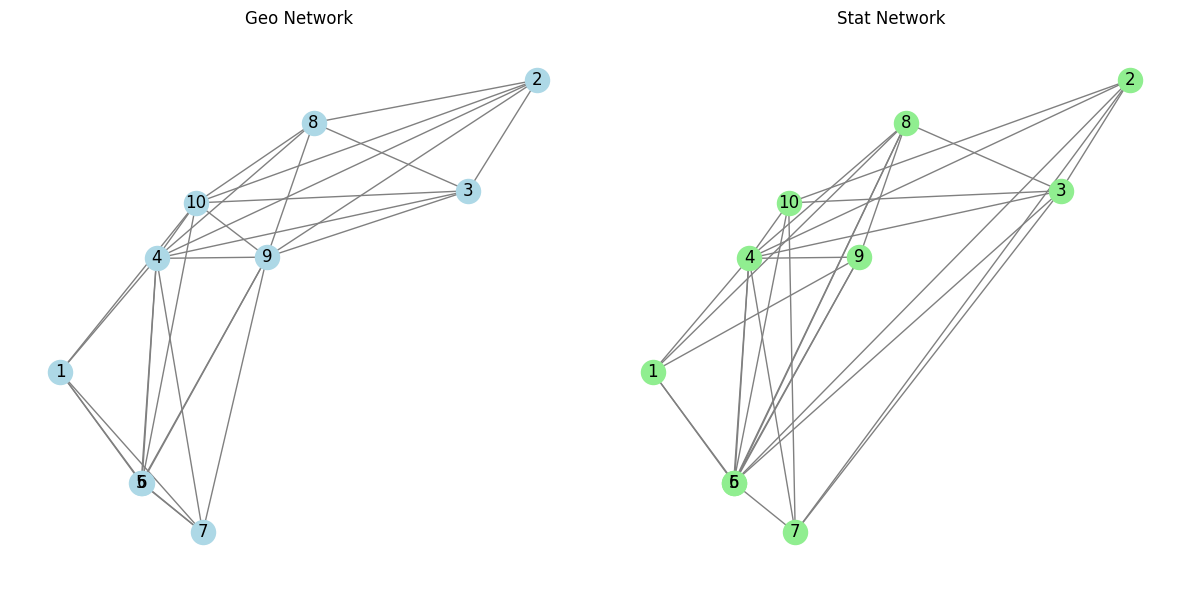

In [ ]:
# Relabel nodes for both networks so that they start from 1 instead of 0
G_geo_relabel = nx.relabel_nodes(G_geo, {i: i+1 for i in G_geo.nodes()})
G_stat_relabel = nx.relabel_nodes(G_stat, {i: i+1 for i in G_stat.nodes()})

# Define a common position dictionary based on geo coordinates
# This ensures that node 1, node 2, etc. appear at the same locations in both visualizations
common_pos = {i+1: (geo_station_data.loc[i, "longitude"], geo_station_data.loc[i, "latitude"])
              for i in range(len(geo_station_data))}

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Geo network using the common layout
nx.draw(G_geo_relabel, pos=common_pos, ax=ax1, with_labels=True, node_color='lightblue', edge_color='gray')
ax1.set_title("Geo Network")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Plot Stat network using the same common layout
nx.draw(G_stat_relabel, pos=common_pos, ax=ax2, with_labels=True, node_color='lightgreen', edge_color='gray')
ax2.set_title("Stat Network")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

 **TASK 2.3:** Analyze Federated Learning (FL) Network Connectivity
Your task is to implement the function analyze_network(G) to analyze the connectivity of a given Federated Learning (FL) network graph G. This function will provide insights into the network structure by computing and visualizing key connectivity properties.

Compute and Plot Node Degrees
Calculate the degree of each node (i.e., the number of connections).
Create a bar plot displaying the node degrees.
Compute the Laplacian Matrix
Compute the Laplacian matrix L of the graph.
Convert L to an array format using .toarray() if necessary.
Analyze Eigenvalues and Eigenvectors
Compute the eigenvalues and eigenvectors of L.
Identify the second smallest eigenvalue (also known as the algebraic connectivity) and a corresponding eigenvector (Fiedler vector).
Plot this eigenvector to visualize network connectivity.

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

def analyze_network(G):
    """
    Analyzes the connectivity of the FL network by:
    - Plotting node degrees.
    - Computing and plotting the eigenvector corresponding to the second smallest eigenvalue of the Laplacian matrix.
    """
    # Compute the degree of each node
    degrees = [G.degree(n) for n in G.nodes()]

    # Compute Laplacian matrix
    L = nx.laplacian_matrix(G).toarray()  # Convert to dense array for eigenvalue computations

    # Compute eigenvalues and eigenvectors of the Laplacian matrix
    eigvals, eigvecs = eigh(L)  # Compute eigenvalues and eigenvectors

    if len(eigvals) > 1:
        # Second smallest eigenvalue and its eigenvector
        second_smallest_eigenvalue = eigvals[1]
        fiedler_vector = eigvecs[:, 1]

        # Plot node degrees
        plt.figure(figsize=(10, 5))
        plt.bar(range(1, len(degrees) + 1), degrees, color='blue')
        plt.xlabel("Node Index")
        plt.ylabel("Degree")
        plt.title("Node Degrees")
        plt.show()

        # Plot Fiedler vector entries
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(fiedler_vector) + 1), fiedler_vector, marker="o", color='green')
        plt.xlabel("Node Index")
        plt.ylabel("Eigenvector Entry")
        plt.title("Fiedler Eigenvector (Second Smallest Eigenvalue)")
        plt.show()

        print(f"Second smallest eigenvalue (algebraic connectivity): {second_smallest_eigenvalue}")
    else:
        print("Not enough connected nodes to compute the second smallest eigenvalue.")


Analyzing network structure for geo-based graph:


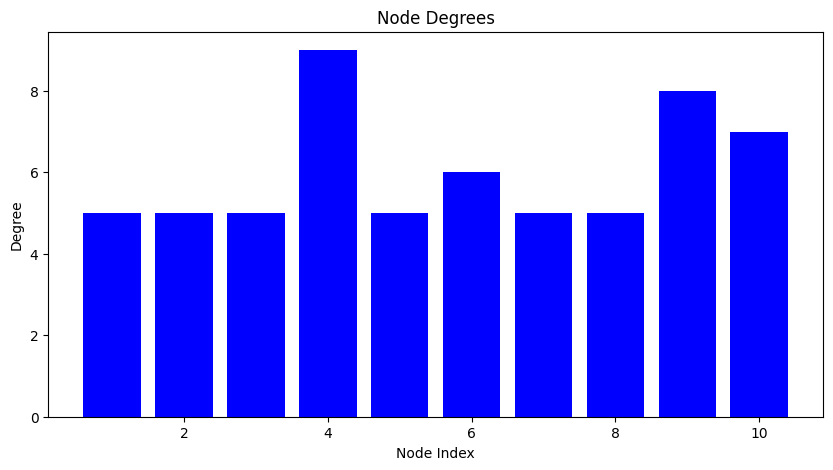

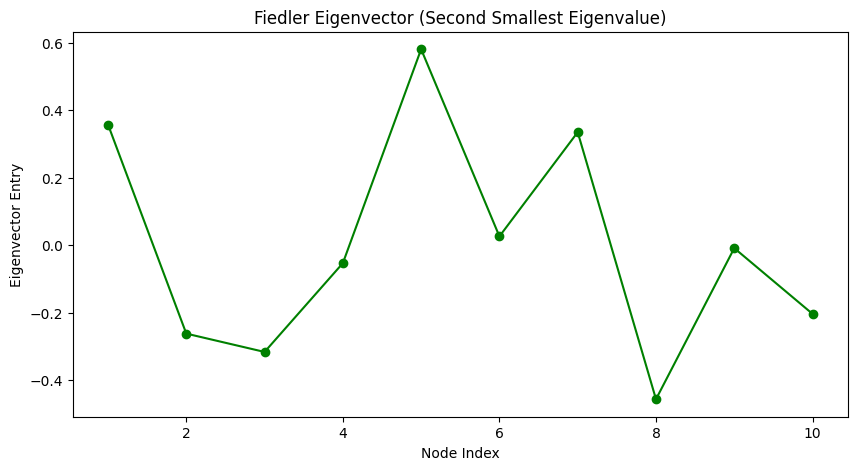

Second smallest eigenvalue (algebraic connectivity): 6.091424073195785


In [ ]:
print("Analyzing network structure for geo-based graph:")
analyze_network(G_geo)

Analyzing network structure for statistics-based graph:


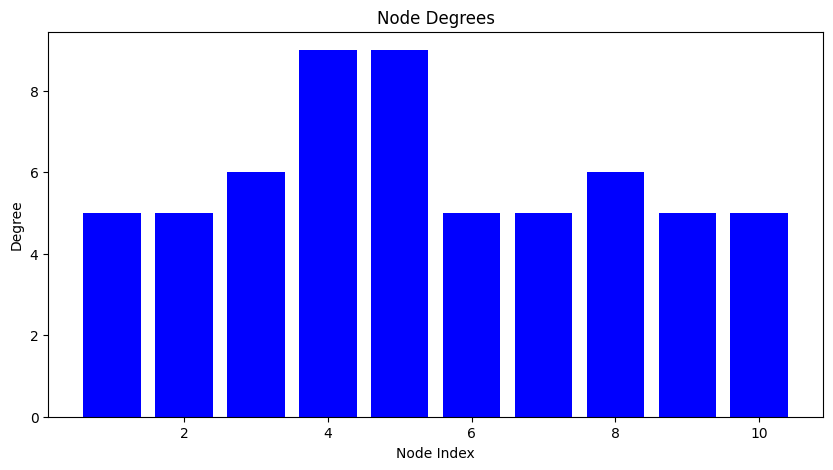

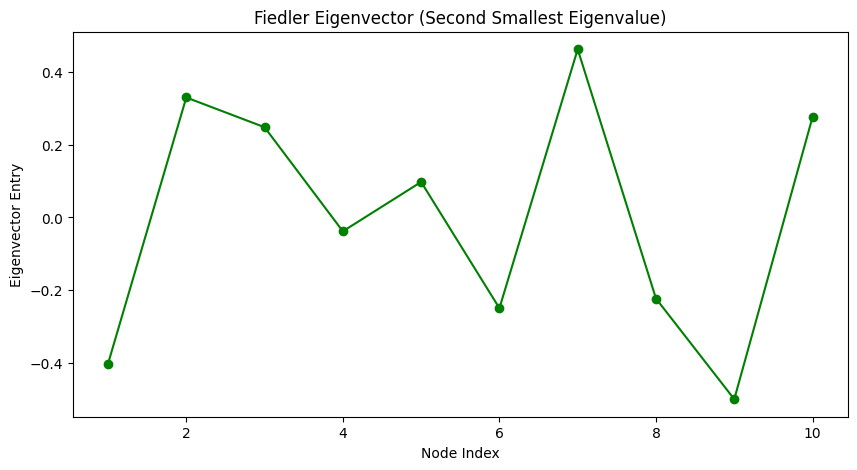

Second smallest eigenvalue (algebraic connectivity): 16.279404712643846


In [ ]:
print("Analyzing network structure for statistics-based graph:")
analyze_network(G_stat)

**TASK 2.4:** Local Averaging for Federated Learning
Your task is to implement the function local_averaging(G), which simulates a simple federated learning algorithm over a FL network that is provided as inputG (networkx.Graph). This function will estimate node-level temperatures using local neighbor data and evaluate the prediction error.

**For each node in the graph:**

Predict the average temperature by computing the mean temperature of its neighbors’ datasets.
If a node has no neighbors, use its own dataset’s average as the prediction.
Compute the actual average temperature for the node.
Calculate the prediction error as the difference between the predicted and actual average temperatures.
Store the error in a dictionary prediction_errors with the node index as the key.
The function should return the dictionary prediction_errors.
Use local_averaging() to compute prediction errors for both:

Geo-based network (G_geo)
Stat-based network (G_stat)
Format the Results in a DataFrame
Construct a Pandas DataFrame with the following columns:
"Geo-Based Error" → Prediction errors from G_geo
"Stat-Based Error" → Prediction errors from G_stat
Print the DataFrame to display the results.

In [ ]:
def local_averaging(G):
    """
    Implements a simple federated learning algorithm for a FL network represented by the input `G`, a `networkx.Graph()` object.
    Each node predicts temperature by averaging the local datasets of its neighbors. Computes the actual average temperature for
    each node. Computes and stores the prediction error for each node.

    Parameters:
    G (networkx.Graph): The FL network graph where each node has a 'dataset' attribute.

    Returns:
    dict: A dictionary where keys are node IDs and values are prediction errors.
    """

    # Initialize dictionary to store prediction errors
    prediction_errors = {}

    # Loop over all nodes in the graph
    for node in G.nodes():
        # Get the local dataset of the node (a numpy array of temperatures)
        node_data = G.nodes[node]['dataset']

        # Compute the actual average temperature for the node
        actual_avg_temp = np.mean(node_data)

        # Get the neighbors of the current node
        neighbors = list(G.neighbors(node))

        # Compute predicted average temperature (mean of neighbors' datasets)
        if neighbors:
            # Get the dataset of each neighbor
            neighbor_data = [np.mean(G.nodes[neighbor]['dataset']) for neighbor in neighbors]
            predicted_avg_temp = np.mean(neighbor_data)  # Mean of neighbors' average temperatures
        else:
            # If no neighbors, use the node's own dataset average
            predicted_avg_temp = actual_avg_temp

        # Compute the prediction error
        prediction_error = predicted_avg_temp - actual_avg_temp

        # Store the error in the dictionary
        prediction_errors[node] = prediction_error

    return prediction_errors

# Compute prediction errors for both networks
prediction_errors_geo = local_averaging(G_geo)
prediction_errors_stat = local_averaging(G_stat)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame({
    "Geo-Based Error": list(prediction_errors_geo.values()),
    "Stat-Based Error": list(prediction_errors_stat.values())
}, index=list(G_geo.nodes()))

# Display the results
print(results_df)


   Geo-Based Error  Stat-Based Error
0        -7.107389         -1.694677
1         6.848141          3.706773
2         1.432471         -0.307620
3         0.966413          0.966413
4         2.637288         -0.904123
5       -12.469832         -8.533987
6        11.270813          2.063615
7        -6.606044          0.073781
8        -8.270796         -2.431390
9        12.844463          7.058151


In [ ]:
# Sanity checks

# Ensure every node has a prediction error
assert len(local_averaging(G_geo)) == 10, "Prediction error missing for some nodes"
assert len(local_averaging(G_stat)) == 10, "Prediction error missing for some nodes"

print('Sanity check passed!')

Sanity check passed!
